In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#from sklearn import svm, datasets
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [2]:
#------------------------------------------------------------------------------
# 1- Split into a training set and a test set using a ShuffleSplit + doing that in parallel for the differrent features to test
#------------------------------------------------------------------------------

from sklearn.model_selection import ShuffleSplit
def split_data(X, y, test_size=.25, train_size=None, norm='StandardScaler') :
    

    rs = ShuffleSplit(n_splits=1, test_size=test_size, train_size=train_size, random_state=0)
    for index_train, index_test in rs.split(y): pass

    X_ = X[:, :-1]
    X_train, X_test = {}, {}
    X_train, X_test = X_[index_train, :], X_[index_test, :]
    y_train, y_test =  y[index_train].copy(), y[index_test].copy()

    print('nb_trial_train : X: %s, y: %s'%(X_train.shape[0], y_train.shape[0]), end='\t')
    print('nb_trial_test : X: %s,  y: %s'%(X_test.shape[0], y_test.shape[0]))
    
    #------------------------------------------------------------------------------
    # 2- normalization TODO: check in mode edge if that normalization is fine
    #------------------------------------------------------------------------------

    if norm=='StandardScaler' :
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    
    if norm=='Quantile_norm' :
        from sklearn.preprocessing import QuantileTransformer
        scaler = QuantileTransformer(output_distribution='normal')
    if norm=='Quantile_uni' :
        from sklearn.preprocessing import QuantileTransformer
        scaler = QuantileTransformer(output_distribution='uniform')
    
    if norm=='RobustScaler' :
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler(quantile_range=(25, 75))
    
    if norm=='PowerTransformer' :
        from sklearn.preprocessing import PowerTransformer
        scaler = PowerTransformer(method='yeo-johnson')
    
    
    X_train_fit = scaler.fit_transform(X_train)
    scaler.fit(X_)
    X_test_fit = scaler.transform(X_test)
    
    
    X_train_fit = np.c_[X_train_fit, X[index_train, -1]]
    X_test_fit = np.c_[X_test_fit, X[index_test, -1]]

    return X_train_fit, X_test_fit, y_train, y_test

In [3]:
#------------------------------------------------------------------------------
# 4- Train a SVM classification model
#------------------------------------------------------------------------------

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def Train_SVM(X_train, y_train, size_c_gamma=32, ax=None, fig=None, plot=None) :


    C_range = np.logspace(-5, 10., size_c_gamma, base=2.)
    gamma_range = np.logspace(-14, 3, size_c_gamma, base=2.)

    #param_grid = [{'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': gamma_range, 'C': C_range}, {'kernel': ['linear'], 'C': C_range}]
    
    liste_kernel = ['rbf']#, 'poly', 'sigmoid']
    param_grid = [{'kernel': liste_kernel, 'gamma': gamma_range, 'C': C_range}]

    
    grid = GridSearchCV(SVC(verbose=False, tol=1e-3, max_iter = -1, class_weight='balanced'),
                        param_grid, verbose=0, scoring='balanced_accuracy', n_jobs=1,) #cv=50, n_jobs=-1
    

    X_train_ = np.zeros((len(X_train), 0))
    X_train_ = np.hstack((X_train_, X_train))
    grid.fit(X_train, y_train.ravel())

    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    
    scores_mean, scores_std = {}, {}
    #for params, mean_score, scores in score_dict:
    for mean_score, std, params in zip(means, stds, grid.cv_results_['params']):
        try :
            scores_mean[params['kernel']].append(mean_score)
            scores_std[params['kernel']].append(std)
        except:
            scores_mean[params['kernel']] = []
            scores_std[params['kernel']] = []
            scores_mean[params['kernel']].append(mean_score)
            scores_std[params['kernel']].append(std)


    # draw heatmap of accuracy as a function of gamma and C
    if plot is None :
        fig, ax = plt.subplots(1,1,figsize=(5,5))

    for x, k in enumerate(['rbf']): #, 'poly', 'sigmoid']) :
        scores = np.array(scores_mean[k]).reshape((gamma_range.shape[0], C_range.shape[0]))
        im = ax.imshow(scores, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
        ax.set_xlabel('gamma')
        ax.set_ylabel('C')

        ax.set_xticks(range(0, len(gamma_range), 5))
        ax.set_yticks(range(0, len(C_range), 5))
        ax.set_xticklabels(['%0.4f'%gamma_range[num] for num in range(0, len(gamma_range), 5)])
        ax.set_yticklabels(['%0.4f'%C_range[num] for num in range(0, len(C_range), 5)])
        
        
        ax.set_title(k)
        fig.colorbar(im, ax=ax, pad=0.01, fraction=.047)
    
    if plot is None :
        fig.tight_layout()
        plt.show()
    
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    if plot is None : return grid
    else : return ax, fig, grid

In [4]:
#------------------------------------------------------------------------------
# 5- Quantitative evaluation of the model quality on the test set
#------------------------------------------------------------------------------
def Quantitative_evaluation(grid, X_test, y_test, classes, ax=None, fig=None, plot=None) :

    import itertools
    from sklearn import metrics
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    
    y_pred = grid.predict(X_test)
    
    #fone_score = np.array(metrics.f1_score(y_test, y_pred, average=None)).mean()
    fone_score = np.array(metrics.balanced_accuracy_score(y_test, y_pred)).mean()
    
    cm = confusion_matrix(y_test, y_pred)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    if plot is None : fig, ax = plt.subplots(1,1,figsize=(5,5))
    im = ax.imshow(norm_cm, interpolation='nearest', cmap=plt.cm.Reds, vmin=0, vmax=1)
    
    ax.set_title('Confusion matrix\n(fone_score on test => Accuracy = %0.2f)' % (fone_score))
    fig.colorbar(im, ax=ax, pad=0.01, fraction=.047)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks) ; ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes) ; ax.set_yticklabels(classes)
    
    thresh = norm_cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 'nb_trial = %s\n\n(%.0f %%)'%(cm[i, j], norm_cm[i, j]*100),
                ha="center", color="white" if norm_cm[i, j] > thresh else "black")
        if i==j :
            ax.text(j, i+0.2, 'f1_score = %.2f'%(metrics.f1_score(y_test, y_pred, average=None)[i]),
                    ha="center", color="white" if norm_cm[i, j] > thresh else "black")

    ax.set_xlabel('Predicted label') ; ax.set_ylabel('True label')
    
    if plot is None :
        plt.tight_layout()
        plt.show()

        return y_pred
    else :
        return ax, fig, y_pred

# Data

In [5]:
import pickle
import os
from ANEMO import read_edf
from ANEMO import ANEMO
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
time = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']
file = os.path.join('parametre', 'Delete_list_trials_velocity_fct.pkl')
with open(file, 'rb') as fichier :
    Delete_list_trials = pickle.load(fichier, encoding='latin1')

file = os.path.join('parametre', 'Delete_list_Bad_trials_velocity.pkl')
with open(file, 'rb') as fichier :
    Bad_Fit = pickle.load(fichier, encoding='latin1')

In [6]:
list_keys_param_fit = ['start_anti', 'tau', 'v_anti', 'latence', 'maxi']
X, y, var = [], [], []
a = 0
for x in range(len(sujet)) :
    
    #-------------------------------------------------------------------------
    file = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.pkl')
    with open(file, 'rb') as fichier : param_exp = pickle.load(fichier, encoding='latin1')
    A = ANEMO(param_exp)
    N_trials, N_blocks = param_exp['N_trials'], param_exp['N_blocks']

    resultats = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.asc')
    data = read_edf(resultats, 'TRIALID')

    file = os.path.join('parametre/goodness_of_fit_'+ sujet[x] +'.pkl')
    with open(file, 'rb') as fichier : goodness_of_fit = pickle.load(fichier, encoding='latin1')
    
    file = os.path.join('parametre/param_Fit_'+ sujet[x] +'_fct_velocity_2_step_False_whitening.pkl')
    with open(file, 'rb') as fichier : param_fit = pickle.load(fichier, encoding='latin1')
    #-------------------------------------------------------------------------

    nb_del_trial = [len(Delete_list_trials[sujet[x]][b]) for b in range(N_blocks)]
    nb_bad_trial = [len(Bad_Fit[sujet[x]][b]) for b in range(N_blocks)]
    print('%s -- nb_Delete_trials = %s, nb_Bad_Fit = %s'%(sujet[x], nb_del_trial, nb_bad_trial))
    #-------------------------------------------------------------------------
    
    for block in range(N_blocks) :
        for trial in range(N_trials) :

            if trial in Delete_list_trials[sujet[x]][block] : y.append(1)
            elif trial in Bad_Fit[sujet[x]][block] : y.append(1)
            else : y.append(0)

            trial_data = trial + N_trials*block
            arg = A.arg(data[trial_data], trial=trial, block=block)
            velocity_NAN = A.velocity_NAN(**arg)[0]
            
            onset = arg.TargetOn-arg.t_0
            start_anti = int(param_fit['start_anti'][block][trial])+onset
            latence = int(param_fit['latence'][block][trial])+onset
            
            after_sacc, before_sacc = 15, 5
            
            #start, stop = latence-200, latence+200
            start = start_anti
            stop = 280
            
            #------------------------------------------------
            # Nb_NaN
            #------------------------------------------------
            if a==0 : var.append('nb_nan_GAP') ; X.append([])
            nb_nan = [x for x in velocity_NAN[arg.StimulusOf-arg.t_0:arg.TargetOn-arg.t_0] if str(x)=='nan']
            X[0].append(len(nb_nan)/len(velocity_NAN[arg.StimulusOf-arg.t_0:arg.TargetOn-arg.t_0]))
            
            if a==0 : var.append('nb_nan_anti') ; X.append([])
            nb_nan = [x for x in velocity_NAN[start_anti:latence] if str(x)=='nan']
            X[1].append(len(nb_nan)/len(velocity_NAN[start_anti:latence]))
            
            if a==0 : var.append('nb_nan_rise') ; X.append([])
            nb_nan = [x for x in velocity_NAN[latence:len(velocity_NAN)-stop] if str(x)=='nan']
            X[2].append(len(nb_nan)/len(velocity_NAN[latence:len(velocity_NAN)-stop]))
            #--------------------------------------------------------------------------------------

            #------------------------------------------------
            # Residu
            #------------------------------------------------
            t1 , res = 0, np.zeros(len(velocity_NAN)-stop)
            for t in range(len(velocity_NAN)-stop) :
                if np.isnan(velocity_NAN[t]) : res[t] = np.nan
                else : res[t] = abs(goodness_of_fit['residual'][block][trial][t1]**.5) ; t1 = t1+1
            
            if a==0 : var.append('residu_GAP') ; X.append([])
            if np.isnan(np.nanmean(res[arg.StimulusOf-arg.t_0:arg.TargetOn-arg.t_0])) : X[3].append(0)
            else : X[3].append(np.nanmean(res[arg.StimulusOf-arg.t_0:arg.TargetOn-arg.t_0]))
                
            if a==0 : var.append('residu_anti') ; X.append([])
            if np.isnan(np.nanmean(res[start_anti:latence])) : X[4].append(0)
            else : X[4].append(np.nanmean(res[start_anti:latence]))
                
            if a==0 : var.append('residu_rise') ; X.append([])
            if np.isnan(np.nanmean(res[latence:])) : X[5].append(0)
            else : X[5].append(np.nanmean(res[latence:]))
            #--------------------------------------------------------------------------------------

            
            #--------------------------------------------------------------------------------------
            sacc = np.zeros(len(arg.trackertime))
            i=0
            for s in range(len(arg.saccades)):
                sacc[i]   = arg.saccades[s][0] # onset sacc
                sacc[i+1] = arg.saccades[s][1] # end sacc
                sacc[i+2] = arg.saccades[s][2] # time sacc
                i = i+3

            onset = arg.TargetOn-arg.t_0
            start_anti = int(param_fit['start_anti'][block][trial] + onset)
            
            fit = A.Equation.fct_position(np.arange(len(arg.trackertime)), arg.data_x, sacc, 
                                          len(arg.saccades), arg.dir_target, start_anti ,
                                          param_fit['v_anti'][block][trial], int(param_fit['latence'][block][trial] + onset),
                                          param_fit['tau'][block][trial], param_fit['maxi'][block][trial], arg.t_0,
                                          arg.px_per_deg, before_sacc, after_sacc, do_whitening=False)
            
            
            d_x = A.data_deg(arg.data_x, arg.StimulusOf,arg.t_0, arg.saccades, before_sacc, after_sacc)
            
            fit = fit[:-stop]
            d_x = d_x[:-stop]
            #--------------------------------------------------------------------------------------


            larg_sacc = 0
            for s in range(len(arg.saccades)) :
                sacc = arg.saccades[s]
                
                start_sacc = int(sacc[0]-arg.t_0)-int(before_sacc)
                stop_sacc = int(sacc[1]-arg.t_0)+int(after_sacc)
                
                if stop_sacc+1 <= len(arg.data_x[:stop]) :
                    
                    if s < len(arg.saccades)-1 :
                        start_s2 = int(arg.saccades[s+1][0]-arg.t_0)-int(before_sacc)-1
                    
                        d_x[stop_sacc:] = d_x[stop_sacc:]-np.mean(d_x[stop_sacc:start_s2])
                        fit[stop_sacc:] = fit[stop_sacc:]-np.mean(fit[stop_sacc:start_s2])
                    else :
                        d_x[stop_sacc:] = d_x[stop_sacc:]-np.mean(d_x[stop_sacc:])
                        fit[stop_sacc:] = fit[stop_sacc:]-np.mean(fit[stop_sacc:])

                    if sacc[0] >= arg.StimulusOf :
                        larg_sacc += abs((arg.data_x[stop_sacc]-arg.data_x[start_sacc-1])/arg.px_per_deg)

            #--------------------------------------------------------------------------------------
            d_x_ss_nan = np.ma.masked_array(d_x[start:], mask=np.isnan(fit[start:])).compressed()
            fit_ss_nan = np.ma.masked_array(fit[start:], mask=np.isnan(fit[start:])).compressed()
            #--------------------------------------------------------------------------------------

            
            error = np.nanmean((d_x_ss_nan - fit_ss_nan)**2)
            if a==0 : var.append('comp_fit_pos') ; X.append([])
            if np.isnan(error): X[6].append(1000)
            else: X[6].append(error)
            
            if a==0 : var.append('larg_sacc') ; X.append([])
            X[7].append(larg_sacc)
            
            if a==0 : var.append('integrale_pos') ; X.append([])
            d_x_2 = np.ma.masked_array(d_x[start_anti:], mask=np.isnan(fit[start_anti:])).compressed()
            # Méthode des trapèzes
            X[8].append(sp.trapz(d_x_2)*arg.dir_target)
            
            if a==0 : var.append('dir_target') ; X.append([])
            X[9].append(arg.dir_target)
            
            
            
            #------------------------------------------------
            # Param_Fit
            #------------------------------------------------
            k = 10
            if a==0 :
                for key in param_fit.keys() :
                    if key in list_keys_param_fit : var.append(key) ; X.append([])
            
            for key in param_fit.keys() :
                if key in list_keys_param_fit :
                    if key=='v_anti':
                        X[k].append(param_fit[key][block][trial]*arg.dir_target)
                    else :
                        X[k].append(param_fit[key][block][trial])
                    k=k+1
            if a==0 : X.append([])
            X[k].append({'sujet':sujet[x], 'block':block, 'trial':trial})
            #--------------------------------------------------------------------------------------
            a=1

AM -- nb_Delete_trials = [0, 1, 0], nb_Bad_Fit = [1, 0, 0]
BMC -- nb_Delete_trials = [2, 7, 2], nb_Bad_Fit = [0, 1, 3]
CS -- nb_Delete_trials = [0, 0, 2], nb_Bad_Fit = [3, 16, 10]
DC -- nb_Delete_trials = [3, 7, 2], nb_Bad_Fit = [6, 7, 6]
FM -- nb_Delete_trials = [22, 11, 3], nb_Bad_Fit = [3, 3, 3]
IP -- nb_Delete_trials = [0, 1, 0], nb_Bad_Fit = [0, 0, 0]
LB -- nb_Delete_trials = [10, 7, 7], nb_Bad_Fit = [12, 11, 6]
OP -- nb_Delete_trials = [29, 19, 22], nb_Bad_Fit = [16, 29, 32]
RS -- nb_Delete_trials = [0, 2, 5], nb_Bad_Fit = [1, 7, 1]
SR -- nb_Delete_trials = [8, 2, 2], nb_Bad_Fit = [5, 23, 5]
TN -- nb_Delete_trials = [7, 3, 5], nb_Bad_Fit = [11, 7, 4]
YK -- nb_Delete_trials = [66, 35, 22], nb_Bad_Fit = [64, 75, 66]


In [7]:
print(var)
print(np.shape(X))

['nb_nan_GAP', 'nb_nan_anti', 'nb_nan_rise', 'residu_GAP', 'residu_anti', 'residu_rise', 'comp_fit_pos', 'larg_sacc', 'integrale_pos', 'dir_target', 'start_anti', 'tau', 'v_anti', 'latence', 'maxi']
(16, 7200)


In [8]:
def figure(norms=['StandardScaler']): #, 'Quantile_norm', 'Quantile_uni', 'RobustScaler', 'PowerTransformer']) :
    
    X1 = np.array(X) ; y1 = np.array(y)
    X1 = X1.transpose()

    for norm in norms :
        print(norm)
        
        X_train, X_test, y_train, y_test = split_data(X1, y1, test_size=.3, train_size=None, norm=norm)
        print('nb_Bad_trial -- y_train : %s -- y_test : %s'%(len(y_train[y_train>0]), len(y_test[y_test>0])))

        fig, ax = plt.subplots(1,2,figsize=(10*2,10))
        X_fit = X_train[:, :-1] ; X_t = X_test[:, :-1]
        
        print(np.shape(X_fit))
        
        classes = ['keep', 'reject']
        ax[0], fig, grid = Train_SVM(X_fit, y_train, size_c_gamma=32, ax=ax[0], fig=fig, plot=True)
        ax[1], fig, y_pred = Quantitative_evaluation(grid, X_t, y_test, classes, ax=ax[1], fig=fig, plot=True)
        
        plt.show()
    return X_train, X_test, y_train, y_test, grid, y_pred

StandardScaler
nb_trial_train : X: 5040, y: 5040	nb_trial_test : X: 2160,  y: 2160
nb_Bad_trial -- y_train : 435 -- y_test : 180
(5040, 15)
The best parameters are {'C': 0.23378038720396177, 'gamma': 0.38233342215886723, 'kernel': 'rbf'} with a score of 0.84


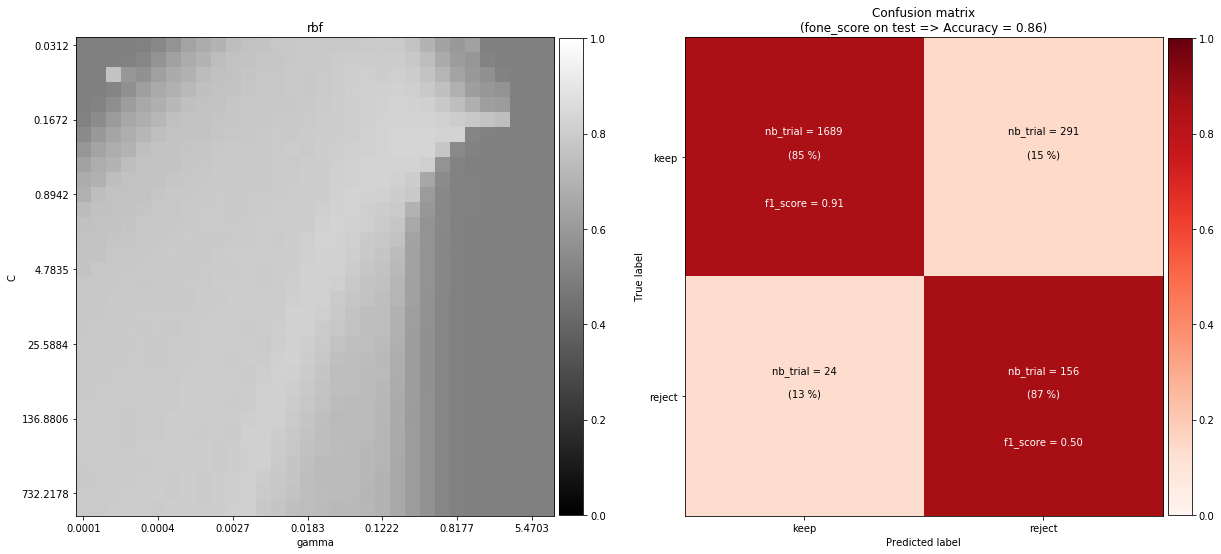

In [9]:
X_train, X_test, y_train, y_test, grid, y_pred = figure()

In [10]:
Good_keep, Bad_keep = [], []
Good_reject, Bad_reject = [], []

for x in range(len(y_pred)) :
    if y_pred[x] == 0 :
        if y_pred[x]==y_test[x] : Good_keep.append(x)
        else : Bad_keep.append(x)
    if y_pred[x] == 1 :
        if y_pred[x]==y_test[x] : Good_reject.append(x)
        else : Bad_reject.append(x)

In [11]:
print('Good_keep :', len(Good_keep))
print('Bad_keep :', len(Bad_keep))
print('Good_reject :', len(Good_reject))
print('Bad_reject :', len(Bad_reject))

Good_keep : 1689
Bad_keep : 24
Good_reject : 156
Bad_reject : 291


In [12]:
extraction_svm = {
    'var' : var,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'grid': grid,
    'y_pred': y_pred,
    'Good_keep': Good_keep,
    'Bad_keep': Bad_keep,
    'Good_reject': Good_reject,
    'Bad_reject': Bad_reject,
    'C': 0.16716617230110212,
    'kernel': 'rbf',
    'gamma': 0.26143353705562145
}

In [13]:
file = os.path.join('extraction_svm.pkl')
with open(file, 'wb') as fichier:
    f = pickle.Pickler(fichier)
    f.dump(extraction_svm)